## 1. Carga de datos
#### Filtro Madrid y elimino variables no relevantes

In [ ]:
import numpy  as np  
import pandas as pd

In [239]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Cargo fichero
raw_data = pd.read_csv("airbnb-listings-extract.csv", sep=';')
print(raw_data.shape)
raw_data.head(5).T  #datos en bruto

#### Filtro y me quedo sólo con los datos correspondientes a Madrid.

In [129]:
# Análisis de España
total_filas = len(raw_data)
spain_count = raw_data[raw_data['Country'] == 'Spain'].shape[0]
spain_percentage = (spain_count / total_filas) * 100

print(f"Total dataset: {total_filas:,} propiedades")
print(f"Total España: {spain_count:,} propiedades ({spain_percentage:.2f}%)")

Total dataset: 14,780 propiedades
Total España: 14,001 propiedades (94.73%)


In [130]:
# Análisis de Madrid 
total_filas = len(raw_data)

# Buscar en Madrid
madrid_filter = raw_data['City'].str.contains('madrid', case=False, na=False)
madrid_count = madrid_filter.sum()
madrid_percentage = (madrid_count / total_filas) * 100

# Buscar otras ciudades de la Comunidad de Madrid
ciudades_madrid = [
    'pozuelo', 'alcalá', 'alcala', 'getafe', 'leganés', 'leganes', 'fuenlabrada', 
    'alcorcón', 'alcorcon', 'móstoles', 'mostoles', 'torrejón', 'torrejon',
    'parla', 'alcobendas', 'aranjuez', 'coslada', 'las rozas', 'majadahonda',
    'rivas', 'collado villalba', 'boadilla', 'san sebastián de los reyes',
    'san sebastian de los reyes', 'tres cantos', 'valdemoro', 'pinto',
    'arganda', 'chinchón', 'chinchon', 'navalcarnero', 'colmenar viejo'
]

otras_madrid_filter = raw_data['City'].str.contains('|'.join(ciudades_madrid), case=False, na=False) & ~madrid_filter
otras_madrid_count = otras_madrid_filter.sum()
otras_madrid_percentage = (otras_madrid_count / total_filas) * 100

# Total Comunidad de Madrid
total_madrid_count = madrid_count + otras_madrid_count
total_madrid_percentage = (total_madrid_count / total_filas) * 100

print(f"Total dataset: {total_filas:,} propiedades")
print(f"Total Madrid: {total_madrid_count:,} propiedades ({total_madrid_percentage:.2f}%)")

Total dataset: 14,780 propiedades
Total Madrid: 13,252 propiedades (89.66%)


Elegir Madrid supone perder cerca de un 11% de datos, lo cual es bastante dado el tamaño del dataset. Pero elegir como muestra España (y perder sólo 5%) puede estar metiendo más variabilidad al modelo para Madrid si los precios entre comunidades son muy diferentes y no habría suficiente muestra representativa del resto de ciudades

In [131]:
# Filtro Madrid
total_madrid_filter = madrid_filter | otras_madrid_filter

# Creo copia filtrada por Madrid 
raw_data_madrid = raw_data[total_madrid_filter].copy() #sólo madrid 

print(f"Dataset original: {raw_data.shape}")
print(f"Dataset Madrid: {raw_data_madrid.shape}")
print(f"Registros eliminados: {len(raw_data) - len(raw_data_madrid):,}")

Dataset original: (14780, 89)
Dataset Madrid: (13252, 89)
Registros eliminados: 1,528


#### Elimino variables no relevantes para caso estudio ya que no voy a hacer procesamiento de texto (Url's, Id's, descripciones y metadata). 
Además elimino las columnas `City`, `Country` por seleccionar sólo Madrid

In [ ]:
# una copia de los datos para trabajar 
data_madrid= raw_data_madrid.copy()

columns_to_drop = [
    'ID', 'Listing Url', 'Scrape ID', 'Thumbnail Url', 'Medium Url', 
    'Picture Url', 'XL Picture Url', 'Host URL', 'Host Thumbnail Url', 
    'Host Picture Url', 'Last Scraped', 'Name', 'Summary', 'Space', 
    'Description', 'Neighborhood Overview', 'License', 'Jurisdiction Names', 
    'Cancellation Policy', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules', 'Host ID', 'Host Name', 
    'Host Location', 'Host About', 'Host Response Time', 'Geolocation', 'Smart Location', 'Market', 'Street', 
    'Host Verifications', 'Neighbourhood', 'Neighbourhood Cleansed', 'State',
    'Neighbourhood Group Cleansed', 'Country Code', 'Calendar Updated', 'City', 'Country',
    'Calendar last Scraped', 'Features', 'Host Neighbourhood'
]

input_madrid= data_madrid.drop(columns=columns_to_drop)  # Aplico la eliminación de variables

print(f"Dataset original: {raw_data.shape}")
print(f"Dataset después de limpieza: {input_madrid.shape}")
input_madrid.head(5).T #sólo madrid sin columnas texto

#### Coloco la variable objetivo en la posición 0 (primera columna) para facilidad del análisis

In [ ]:
# Coloco Price en el índice 0 (primera columna)
price_col = input_madrid['Price']
input_madrid = input_madrid.drop('Price', axis=1)
input_madrid.insert(0, 'Price', price_col)

input_madrid.head(5).T 
#input_madrid.shape

,40,41,42,43,44
Price,28.0,58.0,70.0,26.0,70.0
Experiences Offered,none,none,none,none,none
Host Since,2015-01-06,2015-01-01,2016-04-18,2012-09-08,2013-12-25
Host Response Rate,84.0,100.0,100.0,100.0,100.0
Host Acceptance Rate,NaN,NaN,NaN,NaN,NaN
Host Listings Count,3.0,1.0,2.0,8.0,2.0
Host Total Listings Count,3.0,1.0,2.0,8.0,2.0
Zipcode,28007,28001,28001,28001,28001
Latitude,40.406953,40.425904,40.428352,40.427454,40.428671
Longitude,-3.670894,-3.681647,-3.687155,-3.685763,-3.685423


## 2. División de datos Train / Test
#### Aplico método `train_test_split` para separación fisica en dos archivos .csv (datos de entrenamiento y prueba)

In [195]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(input_madrid, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('airbnb-listings-extract-train.csv', sep=';', decimal='.', index=False)
test.to_csv('airbnb-listings-extract-test.csv', sep=';', decimal='.', index=False)

Dimensiones del dataset de training: (10601, 44)
Dimensiones del dataset de test: (2651, 44)


In [253]:
# Trabajo sólo con el dataset de train

pretrain_data = pd.read_csv('airbnb-listings-extract-train.csv', sep=';', decimal='.') #Train de sólo madrid sin columnas texto
pretrain_data.head(5).T

,0,1,2,3,4
Price,40.0,18.0,59.0,19.0,74.0
Experiences Offered,none,none,none,none,none
Host Since,2013-01-22,2016-01-29,2014-07-26,2016-06-08,2014-03-06
Host Response Rate,100.0,100.0,100.0,80.0,100.0
Host Acceptance Rate,NaN,NaN,NaN,NaN,NaN
Host Listings Count,2.0,4.0,1.0,1.0,2.0
Host Total Listings Count,2.0,4.0,1.0,1.0,2.0
Zipcode,28015,28028,28005,28032,28004
Latitude,40.424541,40.435688,40.413167,40.407085,40.420483
Longitude,-3.711495,-3.671686,-3.708769,-3.607053,-3.703334


## 3. Análisis exploratorio
#### Miro los datos de Train para saber distribuciones estadisticas, outliers, correlaciones.
- VAR númericas Vs categoricas
- Info, describe...
- Histogramas, scatterplots..
- (Matriz correlaciones entre variables)
- (Método de filtrado: `f_reg, mutual_info_reg`)

In [254]:
# Clasificación de variables: Numéricas vs Categóricas
numerical_var = pretrain_data.select_dtypes(include=[np.number]).columns.tolist()
categorical_var = pretrain_data.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"{len(pretrain_data.columns)} variables total | {len(numerical_var)} numéricas | {len(categorical_var)} categóricas")

44 variables total | 35 numéricas | 9 categóricas


In [ ]:
pretrain_data.describe().T

Aqui podemos ver de primeras que variables como `Host Response Rate`, `Has Availability` tienen todos los valores nulos. `Square feet` que a priori que puede parecer una variable interesante tiene muy pocos datos. Hay bastantes variables como `price`, `monthly price`que tienen outliers significativos que convendria filtrar (viendo los valores máximos). `maximum night`tiene una muy alta desviación standar.

In [ ]:
pretrain_data.info()

In [203]:
from ydata_profiling import ProfileReport

profile = ProfileReport(pretrain_data, title="Profiling Report")

In [204]:
profile.to_file("your_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 44/44 [00:00<00:00, 197.24it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 3.1 Análisis exploratorio - Variables numericas

In [255]:
# Variables NUMÉRICAS
numerical_data = []
numerical_var = pretrain_data.select_dtypes(include=[np.number]).columns.tolist()
for col in numerical_var:
    null_pct = (pretrain_data[col].isnull().sum() / len(pretrain_data)) * 100
    numerical_data.append({
        'Variable': col,
        'Dtype': str(pretrain_data[col].dtype),
        'Valores_únicos': pretrain_data[col].nunique(),
        'Nulos_%': round(null_pct, 2),
    })

numerical_df = pd.DataFrame(numerical_data)
display(numerical_df)

,Variable,Dtype,Valores_únicos,Nulos_%
0,Price,float64,269,0.07
1,Host Response Rate,float64,67,12.55
2,Host Acceptance Rate,float64,0,100.00
3,Host Listings Count,float64,47,0.02
4,Host Total Listings Count,float64,47,0.02
5,Latitude,float64,10601,0.00
6,Longitude,float64,10601,0.00
7,Accommodates,int64,15,0.00
8,Bathrooms,float64,16,0.36
9,Bedrooms,float64,10,0.13


La primera variable que vamos a revisar es `price` por ser la variable objetivo:

Percentil 99: 295.28


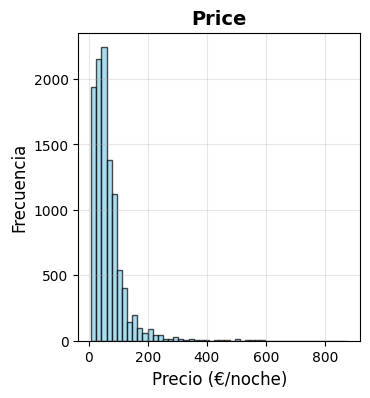

In [219]:
# Histograma de la variable Price
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.hist(pretrain_data['Price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Precio (€/noche)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Price', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

print(f"Percentil 99: {pretrain_data['Price'].quantile(0.99):.2f}")

- Hay outliers que conviene filtrar (hasta 300€/noche cubre el 99% de las muestras)
- Se ve una distribución muy escorda hacia la izquierda, conviene aplicar transformación (por ej. logaritmica) para ver si se centra más a una distribución normal. 

In [256]:
pretrain_data_procesado = pretrain_data[pretrain_data['Price'] <= 300]
datos_filtrados = len(pretrain_data_procesado)

print(f"Datos originales: {len(pretrain_data):,}")
print(f"Datos después filtro: {datos_filtrados:,}")
print(f"Datos eliminados: {len(pretrain_data) - datos_filtrados:,} ({((len(pretrain_data) - datos_filtrados)/len(pretrain_data))*100:.2f}%)")

Datos originales: 10,601
Datos después filtro: 10,509
Datos eliminados: 92 (0.87%)


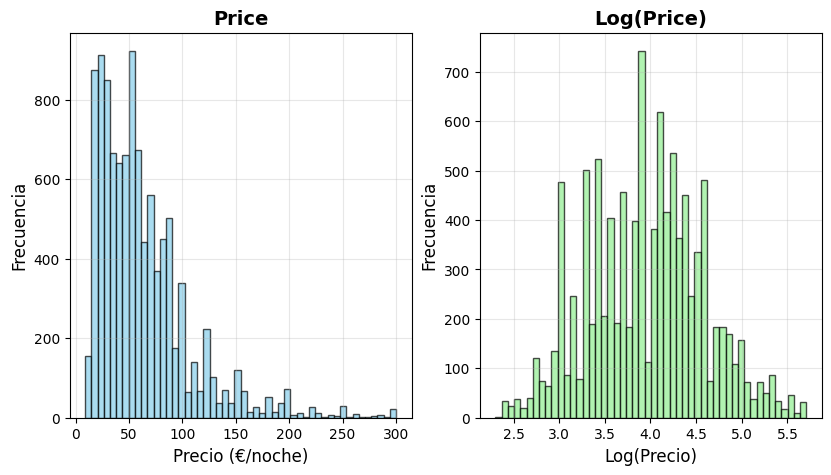

In [257]:
import numpy as np

# Crear nueva variable con logaritmo del precio
pretrain_data_procesado['Price_Log'] = np.log1p(pretrain_data_procesado['Price'])  # log1p = log(1+x) para evitar log(0)

plt.figure(figsize=(15, 5))

# Original
plt.subplot(1, 3, 1)
plt.hist(pretrain_data_procesado['Price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Precio (€/noche)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Price', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Logarítmica
plt.subplot(1, 3, 2)
plt.hist(pretrain_data_procesado['Price_Log'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel('Log(Precio)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Log(Price)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

`Host listings count`, `Host total listings count` parecen tener la misma informacion, colineales (esto lo confirmamos más adelante en la matriz de correlacion), se podría eliminar una y tratar la otra con trasnformacion logaritmica 

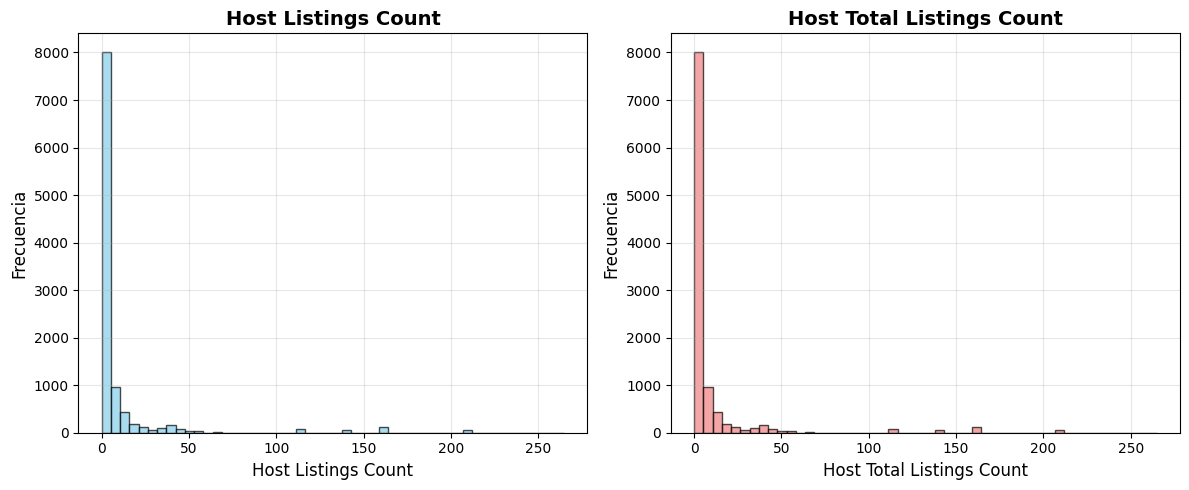

In [231]:
plt.figure(figsize=(12, 5))

# Host Listings Count
plt.subplot(1, 2, 1)
plt.hist(pretrain_data_procesado['Host Listings Count'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Host Listings Count', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Host Listings Count', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Host Total Listings Count
plt.subplot(1, 2, 2)
plt.hist(pretrain_data_procesado['Host Total Listings Count'].dropna(), bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('Host Total Listings Count', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Host Total Listings Count', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

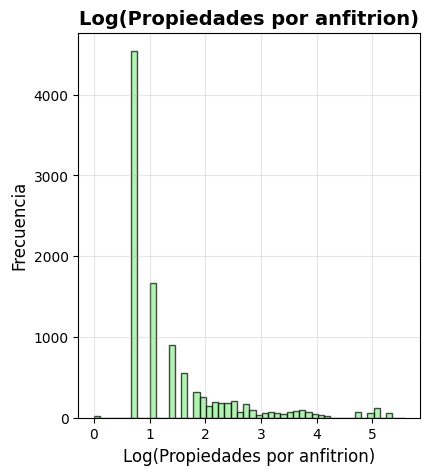

In [258]:
# Imputar valores nulos de Host Listings Count con la mediana antes de la transformación logarítmica
pretrain_data_procesado['Host Listings Count'] = pretrain_data_procesado['Host Listings Count'].fillna(pretrain_data_procesado['Host Listings Count'].median())

# Crear nueva variable con logaritmo del listings count
pretrain_data_procesado['Host Listings Count_Log'] = np.log1p(pretrain_data_procesado['Host Listings Count'])  

plt.figure(figsize=(15, 5))

# Logarítmica
plt.subplot(1, 3, 2)
plt.hist(pretrain_data_procesado['Host Listings Count_Log'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel('Log(Propiedades por anfitrion)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Log(Propiedades por anfitrion)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

`Latitude`, `Longitude` las dejo como están. No hay nulos. Buena distribución

In [259]:
# Imputar valores nulos de Bathrooms, bedrooms y beds con la mediana
pretrain_data_procesado['Bathrooms'] = pretrain_data_procesado['Bathrooms'].fillna(pretrain_data_procesado['Bathrooms'].median())
pretrain_data_procesado['Bedrooms'] = pretrain_data_procesado['Bedrooms'].fillna(pretrain_data_procesado['Bedrooms'].median())
pretrain_data_procesado['Beds'] = pretrain_data_procesado['Beds'].fillna(pretrain_data_procesado['Beds'].median())

`Square feet`, se descarta por alto %valores nulos

`Weekly Price`, `Monthly Price` se descarta por alto %valores nulos (>75%) y porque teniendo una relación (Aunque no lineal) con la variable objetivo, puede añadir confusión al modelo por interpretación errónea (Exactamente weekly price no es el precio/noche*7)

`Security Deposit`, `Cleaning Fee` tienen bastantes valores nulos lo cual indica que probablemente sea porque no apliquen (Es decir el valor sea 0). Además ambas variables están muy escoradas por lo que también conviene mejorar la distribución con una transformación logaritmica. 

In [260]:
# Imputar valores nulos con 0
pretrain_data_procesado['Security Deposit'].fillna(0, inplace=True)
pretrain_data_procesado['Cleaning Fee'].fillna(0, inplace=True)

#Aplicar transformación 
# Crear nueva variable con logaritmo 
pretrain_data_procesado['Security Deposit_Log'] = np.log1p(pretrain_data_procesado['Security Deposit'])  
pretrain_data_procesado['Cleaning Fee_Log'] = np.log1p(pretrain_data_procesado['Cleaning Fee'])  

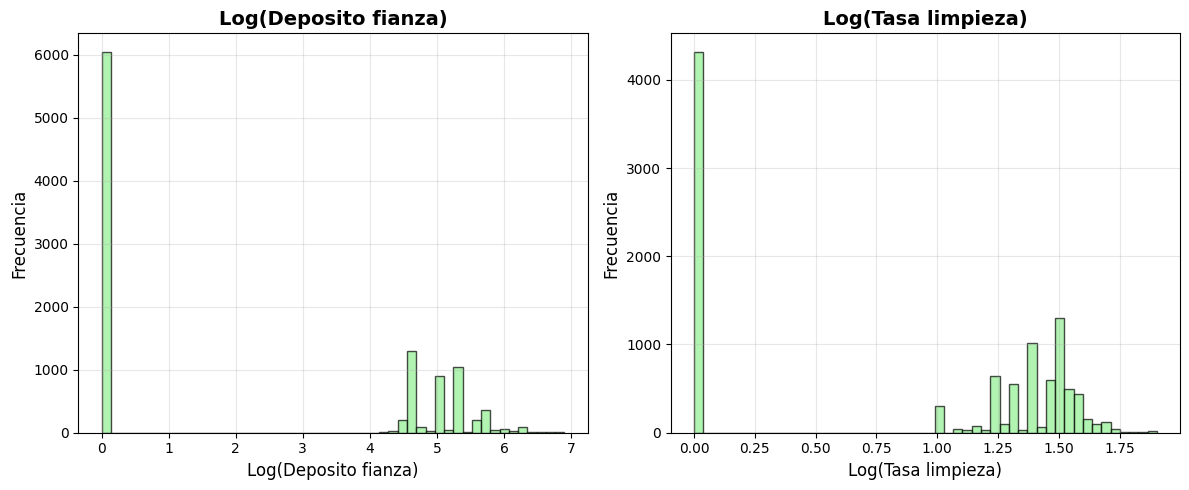

In [241]:
plt.figure(figsize=(12, 5))

# Seecurity Deposit
plt.subplot(1, 2, 1)
plt.hist(pretrain_data_procesado['Security Deposit_Log'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel('Log(Deposito fianza)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Log(Deposito fianza)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Claening fee
plt.subplot(1, 2, 2)
plt.hist(pretrain_data_procesado['Cleaning Fee'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel('Log(Tasa limpieza)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Log(Tasa limpieza)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- `Extra People`, `Reviews Per Month` tienen valores nulos que ha de tratarse como 0 (no hay extracoste, no hay revisiones mensuales) Aplicamos transformación log.
- `Minimum Nights` Aplicamos también transformación log pero no filtramos outliers ya que habrá anfitriones que requieran un minimo de estancia y esto afecte siginificativamente en el precio (y sea útil)

In [270]:
# Imputar valores nulos con 0
pretrain_data_procesado['Extra People'].fillna(0, inplace=True)
pretrain_data_procesado['Reviews per Month'].fillna(0, inplace=True)

#Aplicar transformación 
# Crear nueva variable con logaritmo 
pretrain_data_procesado['Extra People_Log'] = np.log1p(pretrain_data_procesado['Extra People'])  
pretrain_data_procesado['Minimum Nights_Log'] = np.log1p(pretrain_data_procesado['Minimum Nights'])  
pretrain_data_procesado['Reviews per Month'] = np.log1p(pretrain_data_procesado['Reviews per Month'])  

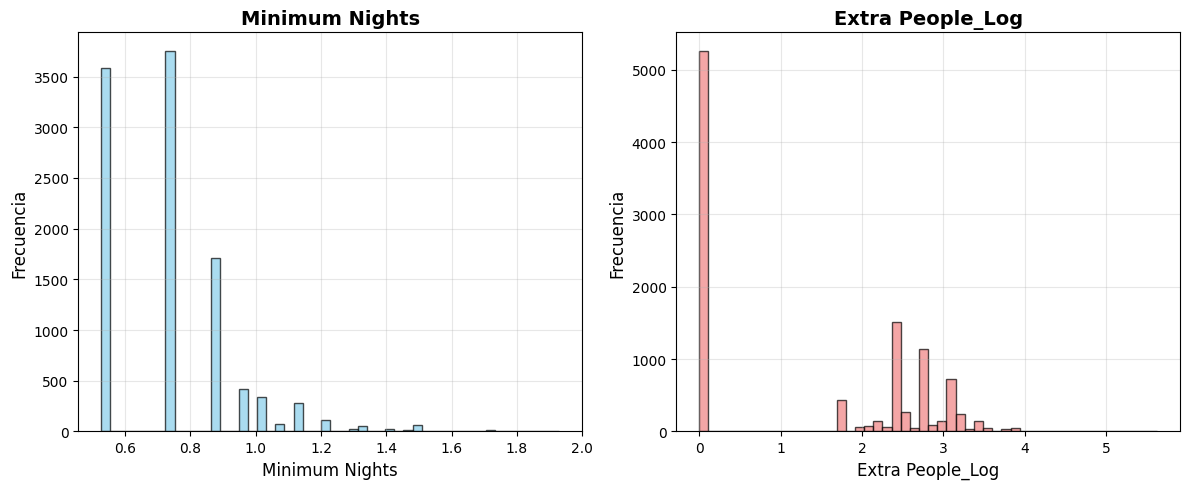

In [247]:
plt.figure(figsize=(12, 5))

# LOG(Extra People)
plt.subplot(1, 2, 2)
plt.hist(pretrain_data_procesado['Extra People_Log'].dropna(), bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('Extra People_Log', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Extra People_Log', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# LOG(Minimum Nights)
plt.subplot(1, 2, 1)
plt.hist(pretrain_data_procesado['Minimum Nights_Log'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Minimum Nights', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Minimum Nights', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- `Availability 30, 60, 90, 365` contiene información redundante y están fuertemente correlacionadas entre si (ver matiz correlación). 

- Hago una nueva variable, tasa de ocupación `Booking Rate` = (365 - availability_365) / 365, y descarto el resto.

In [262]:
pretrain_data_procesado['Booking Rate'] = (365- pretrain_data_procesado['Availability 365'])/365

- `Number of reviews` transformación logaritmica. 

- Resto de valoraciones: `Review Scores...` tienen similar cantidad de valores nulos, lo que puede traducirse en la misma propiedad que no tenga ningun tipo de reseña. Tienen mucho sesgo. Voy a imputar los nulos con la mediana y hacer una nueva variable, puntuación media `Avg Review Score`.

In [ ]:
review_score_columns = [
    'Review Scores Rating',
    'Review Scores Accuracy',
    'Review Scores Cleanliness',
    'Review Scores Checkin',
    'Review Scores Communication',
    'Review Scores Location',
    'Review Scores Value'
]

# Imputar los valores nulos con la mediana de cada columna 
for col in review_score_columns:
    median_value =pretrain_data_procesado[col].median()
    pretrain_data_procesado[col].fillna(median_value, inplace=True)

print("Valores nulos después de la imputación:")
print(pretrain_data_procesado[review_score_columns].isnull().sum())

Valores nulos después de la imputación:
Review Scores Rating           0
Review Scores Accuracy         0
Review Scores Cleanliness      0
Review Scores Checkin          0
Review Scores Communication    0
Review Scores Location         0
Review Scores Value            0
dtype: int64


In [266]:
# Crear una copia temporal para no modificar la original antes del cálculo
df_temp_scores = pretrain_data_procesado[review_score_columns].copy()

# Estandarizar 'Review Scores Rating'
df_temp_scores['Review Scores Rating'] = df_temp_scores['Review Scores Rating'] / 10

# Verificamos los rangos para asegurarnos de que la escala es correcta
print("\nValores máximos después de estandarizar 'rating':")
print(df_temp_scores.max())


Valores máximos después de estandarizar 'rating':
Review Scores Rating            1.0
Review Scores Accuracy         10.0
Review Scores Cleanliness      10.0
Review Scores Checkin          10.0
Review Scores Communication    10.0
Review Scores Location         10.0
Review Scores Value            10.0
dtype: float64


In [269]:
# Calcular la media de todas las columnas de puntuación para cada fila (axis=1)
pretrain_data_procesado['Avg Review Scores'] = df_temp_scores.mean(axis=1)

# Verificamos el resultado
print("\nPrimeras 5 filas con la nueva columna 'avg_review_score':")
print(pretrain_data_procesado[['Avg Review Scores'] + review_score_columns].head())


Primeras 5 filas con la nueva columna 'avg_review_score':
   Avg Review Scores  Review Scores Rating  Review Scores Accuracy  \
0           7.690000              7.690000                     9.0   
1           7.535714              7.535714                     9.0   
2           8.270000              8.270000                     9.0   
3           7.971429              7.971429                     8.0   
4           8.567143              8.567143                    10.0   

   Review Scores Cleanliness  Review Scores Checkin  \
0                        8.0                    9.0   
1                        9.0                    9.0   
2                        9.0                   10.0   
3                       10.0                   10.0   
4                       10.0                   10.0   

   Review Scores Communication  Review Scores Location  Review Scores Value  
0                          9.0                     9.0                  9.0  
1                          8.0   

Var numercias:

| Atributo | descripción | conclusión |
|:---------|:------------|:-----------|
| *Price* | precio €/noche | Filtro outliers y trasnformación log1p |
| *Host Acceptance Rate* | % solicitudes aceptadas por anfitrión | Eliminar por alto valor de nulos|
| *Host Response Rate* | % respuesta del anfitrión | Dejar en standby |
| *Host Listings Count* | nºprop del anfitrión | Imputar nulos con mediana y transformacion log1p |
| *Host Total Listings Count* | nºtotal prop del anfitrión | Eliminar por redundancia con Host Listings Count |
| *Latitude* | latitud | dejar|
| *Longitude* | longitud | dejar|
| *Accommodates* | capacidad de alojamiento | dejar|
| *Bathrooms* | nºbaños | imputar nulos con mediana, dejar 0 (baño compartido?¿)|
| *Bedrooms* | nºhabitaciones | imputar nulos con mediana, dejar 0 (casa diafana?¿), ver posible correlacion|
| *Bed* | nºcamas | ver posible correlacion|
| *Square feet* | m2 | Eliminar por alto valor de nulos|
| *Weekly Price* | precio €/semana | Eliminar por alto valor de nulos|
| *Monthly Price* | precio €/mes | Eliminar por alto valor de nulos|
| *Security Deposit* | fianza | Imputar nulos con 0 y transformación log1p |
| *Cleaning fee* | tas alimpieza | Imputar nulos con 0 y transformación log1p|
| *Guests Included* | nºHuesped incluido | dejar|
| *Extra People* | huesped extra | Imputar nulos con 0 y transformación log1p|
| *Minimum Nights* | minimo noches | transformación log1p|
| *Maximum Nights* | máximo noches | Eliminar alta desv. |
| *Has Availability* | disponibilidad actual | Eliminar por alto valor de nulos|
| *Availability 30* | disponibilidad 30 dias | Eliminar alta correlacion |
| *Availability 60* | disponibilidad 60 dias | Eliminar alta correlacion |
| *Availability 90* | disponibilidad 90 dias | Eliminar alta correlacion |
| *Availability 365* | disponibilidad 365 dias | Eliminar y crear nueva variable booking_rate |
| *Number of Reviews* | nºreseñas | transformación log1p|
| *Review Scores Rating* | rating puntuación | Eliminar|
| *Review Scores Accuracy* | puntuación precision | Eliminar|
| *Review Scores Cleanliness* | puntuación limpieza | Eliminar|
| *Review Scores Checkin* | puntuación Checkin | Eliminar|
| *Review Scores Communication* | puntuación comunicación | Eliminar|
| *Review Scores Location* | puntuación localización | Eliminar|
| *Review Scores Value* | valor puntuación | Eliminar y crear nueva variable con la media de reviews|
| *Calculated Host Listings Count* | nºcalculado prop del anfitrión | Eliminar por redundancia con Host Listings Count |
| *Reviews Per Month* | revisiones al mes | Imputar nulos con 0 y transformacion log1p |

### 3.2 Análisis exploratorio - Variables categórcias

Var categoricas:

| Atributo | descripción | conclusión |
|:---------|:------------|:-----------|
| *Experiences Offered* | experiencias adicionales al piso | |
| *Host Since* | fecha registro del anfitrión en Airbnb | trasnformar a antigüedad en días --> imputar nulos = mediana|
| *City* | ciudad | Filtrado previamente por Madrid: eliminar |
| *ZipCode* | código barras | Standby |
| *Country* | pais | Eliminar |
| *Property Type* | tipo de propiedad | |
| *Room Type* | tipo de habitación | |
| *Bed Type* | tipo de cama | |
| *Amenities* | comodidades adicionales | Standby |
| *First Review* | fecha primera reseña | Hacer la diferencia a dias con Last Review y tratar nulos=0|
| *Last Review* | fecha última reseña | 

Var categoricas:

| Atributo | descripción | conclusión |
|:---------|:------------|:-----------|
| *Experiences Offered* | experiencias adicionales al piso | |
| *Host Since* | fecha registro del anfitrión en Airbnb | Pasar a días --> númerica y tratar nulos =0|
| *City* | ciudad | Filtrado previamente por Madrid: eliminar |
| *ZipCode* | código barras | Standby |
| *Country* | pais | Eliminar |
| *Property Type* | tipo de propiedad | |
| *Room Type* | tipo de habitación | |
| *Bed Type* | tipo de cama | |
| *Amenities* | comodidades adicionales | Standby |
| *Has Availability* | disponibilidad actual | Eliminar por alto valor de nulos|
| *First Review* | fecha primera reseña | Hacer la diferencia a dias con Last Review y tratar nulos=0|
| *Last Review* | fecha última reseña | 

In [273]:
# Variables CATEGÓRICAS
categorical_data = []
categorical_var = pretrain_data_procesado.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_var:
    null_pct = (pretrain_data_procesado[col].isnull().sum() / len(pretrain_data_procesado)) * 100
    categorical_data.append({
        'Variable': col,
        'Dtype': str(pretrain_data_procesado[col].dtype),
        'Valores_únicos': pretrain_data_procesado[col].nunique(),
        'Nulos_%': round(null_pct, 2),
    })

categorical_df = pd.DataFrame(categorical_data)
display(categorical_df)

,Variable,Dtype,Valores_únicos,Nulos_%
0,Experiences Offered,object,1,0.00
1,Host Since,object,1996,0.02
2,Zipcode,object,74,3.24
3,Property Type,object,22,0.00
4,Room Type,object,3,0.00
5,Bed Type,object,5,0.00
6,Amenities,object,8988,0.75
7,First Review,object,1508,20.33
8,Last Review,object,652,20.34


`Experiences Offered`, sólo tiene un valor único "NONE" , no aporta información, se puede eliminar

In [274]:
print(pretrain_data_procesado['Experiences Offered'].value_counts())

Experiences Offered
none    10509
Name: count, dtype: int64


`Host since`, propietarios más antiguos pueden dar informacion relevante sobre mejores o peores precios y dado que tiene casi el 100% de los datos vamos a transformarla en antiguedad como la diferencia con la fecha máx (7/04/2017)

`Propierty Type`, `Room Type`, `Bed Type` veamos valores únicos e histograma


ANÁLISIS DE PROPERTY TYPE
Valores únicos: 22

Distribución de frecuencias:
Property Type
Apartment             8691
House                  749
Condominium            281
Bed & Breakfast        269
Loft                   216
Other                  166
Dorm                    35
Guesthouse              29
Chalet                  20
Hostel                  15
Serviced apartment      10
Townhouse                8
Boutique hotel           5
Earth House              3
Guest suite              3
Villa                    2
Casa particular          2
Timeshare                1
Bungalow                 1
Boat                     1
Camper/RV                1
Tent                     1
Name: count, dtype: int64

--------------------------------------------------

ANÁLISIS DE ROOM TYPE
Valores únicos: 3

Distribución de frecuencias:
Room Type
Entire home/apt    6231
Private room       4116
Shared room         162
Name: count, dtype: int64

--------------------------------------------------

ANÁLIS

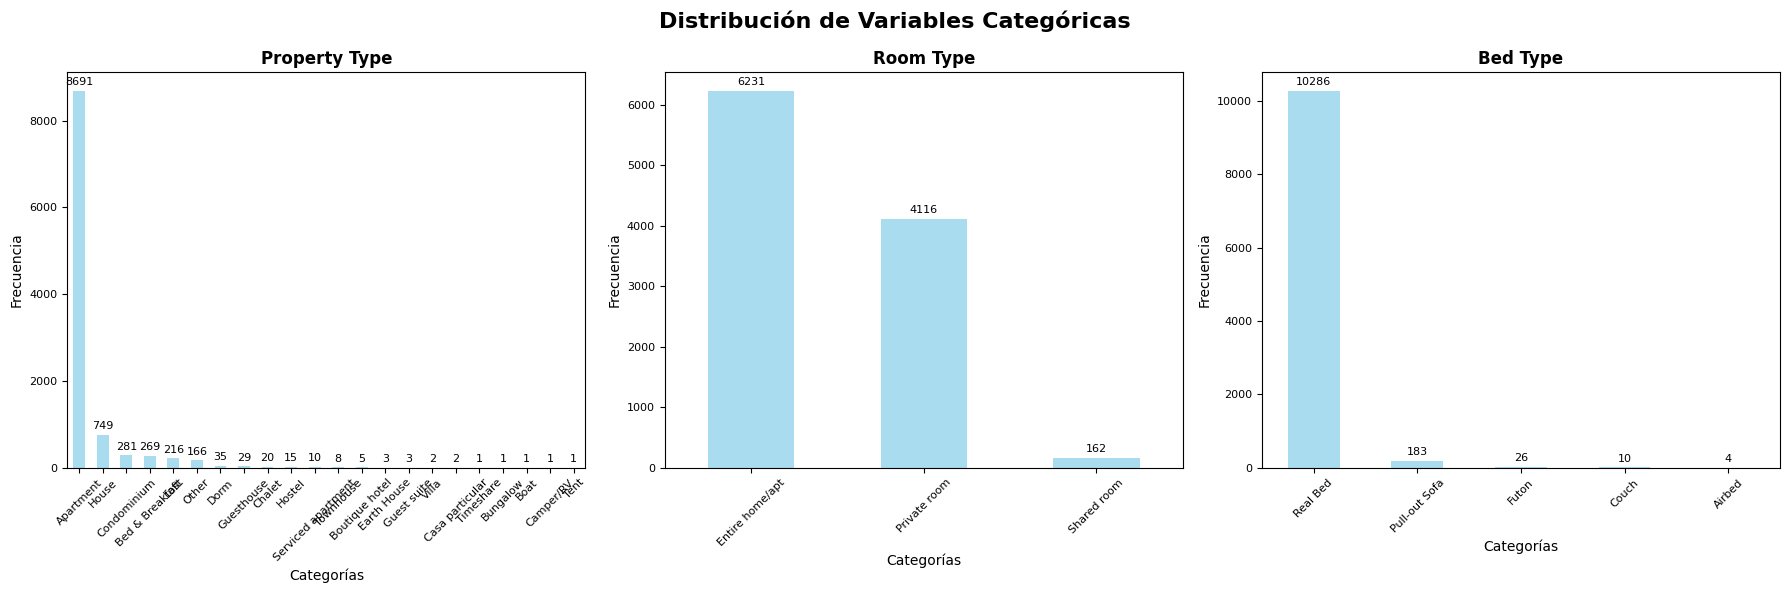

In [275]:
# Análisis de Property Type, Room Type, Bed Type con histogramas
import matplotlib.pyplot as plt
import seaborn as sns

variables_categoricas = ['Property Type', 'Room Type', 'Bed Type']

# Configurar el estilo de los gráficos
plt.style.use('default')
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distribución de Variables Categóricas', fontsize=16, fontweight='bold')

for i, var in enumerate(variables_categoricas):
    print(f"\n{'='*50}")
    print(f"ANÁLISIS DE {var.upper()}")
    print(f"{'='*50}")
    
    # Valores únicos
    valores_unicos = pretrain_data_procesado[var].nunique()
    print(f"Valores únicos: {valores_unicos}")
    
    # Distribución de frecuencias
    print(f"\nDistribución de frecuencias:")
    distribucion = pretrain_data_procesado[var].value_counts()
    print(distribucion)
    
    # Crear histograma
    ax = axes[i]
    distribucion.plot(kind='bar', ax=ax, color='skyblue', alpha=0.7)
    ax.set_title(f'{var}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Categorías', fontsize=10)
    ax.set_ylabel('Frecuencia', fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    # Añadir valores en las barras
    for j, v in enumerate(distribucion.values):
        ax.text(j, v + max(distribucion.values) * 0.01, str(v), 
                ha='center', va='bottom', fontsize=8)
    
    print(f"\n" + "-"*50)

plt.tight_layout()
plt.show()

In [ ]:
pretrain_data.info()

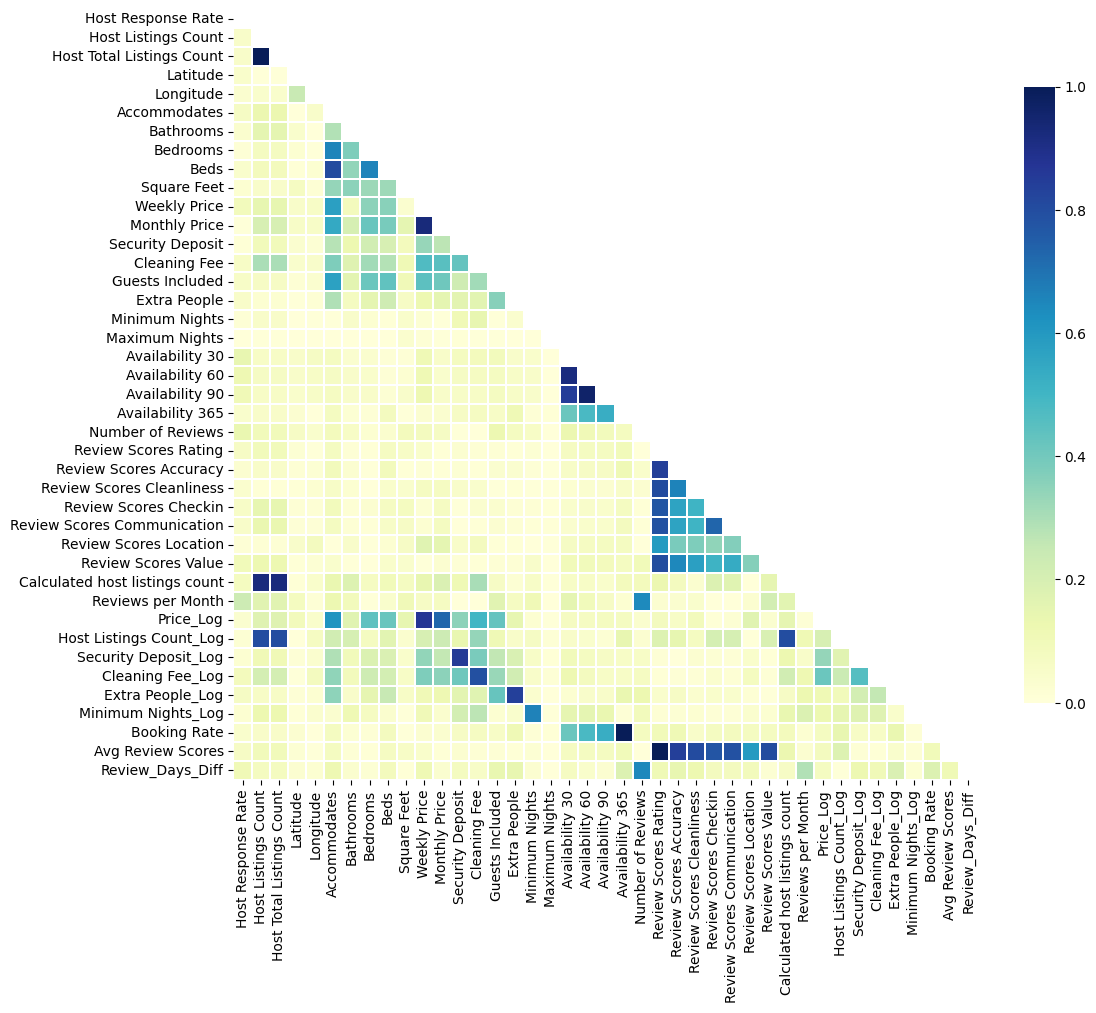

In [ ]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(pretrain_data_procesado.drop(['Price'], axis=1).corr(numeric_only=True))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

## 4. Preprocesado datos Train
#### Proceso datos de train en función de las conclusiones estadisticas
- Imputación de valores ausentes
- Codificación variables categoricas
- (Eliminación por random forest/Lasso, muchos Nan, alta correlación..)
- (Generación y transformación de variables)
- (Filtrado outliers)

`Property Type` agrupo por Apartment, House, Condominium, Bed & Breakfast, Loft y el resto todo en Other. Hago un mean encoding con el precio (Esto puedo hacerlo porque ya tengo la división de train y test, y lo estoy haciendo sólo teniendo en cuenta los datos de train). Crear variables dummy generaria demasiadas caracteristicas nuevas.

`First Review`, `Last Review` Voya usar la diferencia en días para tratarla como númerica (y sacar la frecuencia de revisones conjunto a `Number of reviews`más adelante)

In [276]:
import pandas as pd

# Convertir a datetime
pretrain_data_procesado['First Review'] = pd.to_datetime(pretrain_data_procesado['First Review'], errors='coerce')
pretrain_data_procesado['Last Review'] = pd.to_datetime(pretrain_data_procesado['Last Review'], errors='coerce')

# Calcular diferencia en días
pretrain_data_procesado['Review_Days_Diff'] = (pretrain_data_procesado['Last Review'] - pretrain_data_procesado['First Review']).dt.days

# Rellenar valores nulos con 0 y aseguro que no haya valores negativos
pretrain_data_procesado['Review_Days_Diff'] = pretrain_data_procesado['Review_Days_Diff'].fillna(0)
pretrain_data_procesado['Review_Days_Diff'] = pretrain_data_procesado['Review_Days_Diff'].clip(lower=0)

# Nueva columna
print(f"Nueva columna 'Review_Days_Diff' creada:")
print(f"Tipo de datos: {pretrain_data_procesado['Review_Days_Diff'].dtype}")
print(f"Valores únicos: {pretrain_data_procesado['Review_Days_Diff'].nunique()}")

print(pretrain_data_procesado['Review_Days_Diff'].describe())

# Mostrar algunos ejemplos
print(f"\nPrimeros 10 valores:")
print(pretrain_data_procesado[['First Review', 'Last Review', 'Review_Days_Diff']].head(5))

Nueva columna 'Review_Days_Diff' creada:
Tipo de datos: float64
Valores únicos: 1494
count    10509.000000
mean       323.732325
std        410.427696
min          0.000000
25%          0.000000
50%        169.000000
75%        497.000000
max       2519.000000
Name: Review_Days_Diff, dtype: float64

Primeros 10 valores:
  First Review Last Review  Review_Days_Diff
0   2013-10-08  2016-09-19            1077.0
1   2016-05-16  2016-08-19              95.0
2   2014-08-11  2017-03-19             951.0
3   2016-10-26  2016-10-30               4.0
4   2015-03-15  2017-03-31             747.0


- `Host Acceptance Rate`, `Has Availability`: puedo eliminarlas porque todos son valores nulos 

- `First Review`, `Last Review`: puedo eliminarlas porque las transforme en `Review_Days_Diff`

- `Zipcode`, `Amenities`,`Propierty Type`, `Room Type`, `Bed Type`: las elimino y no la voy a incluir de momento

In [277]:
# Eliminar columnas especificadas del dataset pretrain_data
columns_to_remove = [
    'Experiences Offered', 'Host Since', 'Host Acceptance Rate', 'Has Availability',
    'First Review', 'Last Review', 'Zipcode', 'Amenities', 'Property Type', 
    'Room Type', 'Bed Type'
]

# Eliminar las columnas existentes
pretrain_data_procesado = pretrain_data_procesado.drop(columns=columns_to_remove)

print(f"\nDataset original: {pretrain_data.shape}")
print(f"Dataset después de eliminar columnas: {pretrain_data_procesado.shape}")
print(f"Columnas eliminadas: {len(columns_to_remove)}")

# Mostrar las primeras filas del dataset limpio
pretrain_data_procesado.head().T


Dataset original: (10601, 44)
Dataset después de eliminar columnas: (10509, 42)
Columnas eliminadas: 11


,0,1,2,3,4
Price,40.000000,18.000000,59.000000,19.000000,74.000000
Host Response Rate,100.000000,100.000000,100.000000,80.000000,100.000000
Host Listings Count,2.000000,4.000000,1.000000,1.000000,2.000000
Host Total Listings Count,2.000000,4.000000,1.000000,1.000000,2.000000
Latitude,40.424541,40.435688,40.413167,40.407085,40.420483
Longitude,-3.711495,-3.671686,-3.708769,-3.607053,-3.703334
Accommodates,2.000000,2.000000,2.000000,1.000000,4.000000
Bathrooms,1.000000,1.000000,1.000000,1.000000,1.000000
Bedrooms,1.000000,1.000000,1.000000,1.000000,1.000000
Beds,1.000000,2.000000,1.000000,1.000000,2.000000


In [146]:
# IMPUTACIÓN SIMPLE 

# Imputar con mediana (más robusta que la media ante outliers)
for col in pretrain_data_final.columns:
    if pretrain_data_final[col].isnull().any():
            median_value = pretrain_data_final[col].median()
            pretrain_data_final[col] = pretrain_data_final[col].fillna(median_value)
            print(f"• {col}: imputado con mediana = {median_value:.2f}")

# Verificar resultado
print(f"\nNulos DESPUÉS:")
nulls_after = pretrain_data_final.isnull().sum()
nulls_after = nulls_after[nulls_after > 0]

if len(nulls_after) == 0:
    print("No quedan valores nulos")
else:
    print("Aún quedan nulos:")
    for col, count in nulls_after.items():
        print(f"• {col}: {count}")



• Price: imputado con mediana = 52.00
• Host Response Rate: imputado con mediana = 100.00
• Host Listings Count: imputado con mediana = 2.00
• Host Total Listings Count: imputado con mediana = 2.00
• Bathrooms: imputado con mediana = 1.00
• Bedrooms: imputado con mediana = 1.00
• Beds: imputado con mediana = 1.00
• Square Feet: imputado con mediana = 108.00
• Weekly Price: imputado con mediana = 350.00
• Monthly Price: imputado con mediana = 1200.00
• Security Deposit: imputado con mediana = 150.00
• Cleaning Fee: imputado con mediana = 25.00
• Review Scores Rating: imputado con mediana = 94.00
• Review Scores Accuracy: imputado con mediana = 10.00
• Review Scores Cleanliness: imputado con mediana = 10.00
• Review Scores Checkin: imputado con mediana = 10.00
• Review Scores Communication: imputado con mediana = 10.00
• Review Scores Location: imputado con mediana = 10.00
• Review Scores Value: imputado con mediana = 9.00
• Reviews per Month: imputado con mediana = 1.26

Nulos DESPUÉS:


## 5. Procesado datos Test
#### Aplico las mismas transformaciones que en Train

RESUMEN TRANSFORMACIONES EN TRAIN

In [ ]:
#CARGO DATOS TRAIN
pretrain_data = pd.read_csv('airbnb-listings-extract-train.csv', sep=';', decimal='.') #Train de sólo madrid sin columnas texto


#COPIA PARA APLICAR LAS TRANSFORMACIONES
pretrain_data_final = pretrain_data.copy() #Train de sólo madrid sin columnas texto con transformaciones aplicadas



#COLUMNA NUEVA 'Review_Days_Diff'
# Convertir a datetime
pretrain_data_final['First Review'] = pd.to_datetime(pretrain_data_final['First Review'], errors='coerce')
pretrain_data_final['Last Review'] = pd.to_datetime(pretrain_data_final['Last Review'], errors='coerce')
# Calcular diferencia en días
pretrain_data_final['Review_Days_Diff'] = (pretrain_data_final['Last Review'] - pretrain_data_final['First Review']).dt.days
# Rellenar valores nulos con 0 y aseguro que no haya valores negativos
pretrain_data_final['Review_Days_Diff'] = pretrain_data_final['Review_Days_Diff'].fillna(0)
pretrain_data_final['Review_Days_Diff'] = pretrain_data_final['Review_Days_Diff'].clip(lower=0)


#ELIMINO COLUMNAS
# Eliminar columnas especificadas del dataset pretrain_data
columns_to_remove = [
    'Experiences Offered', 'Host Since', 'Host Acceptance Rate', 'Has Availability',
    'First Review', 'Last Review', 'Zipcode', 'Amenities', 'Property Type', 
    'Room Type', 'Bed Type'
]
# Eliminar las columnas existentes
pretrain_data_final = pretrain_data_final.drop(columns=columns_to_remove)


#IMPUTACIÓN NULOS
for col in pretrain_data_final.columns:
    if pretrain_data_final[col].isnull().any():
            median_value = pretrain_data_final[col].median()
            pretrain_data_final[col] = pretrain_data_final[col].fillna(median_value)

In [148]:
pretrain_data_final.head(5).T

,0,1,2,3,4
Price,40.000000,18.000000,59.000000,19.000000,74.000000
Host Response Rate,100.000000,100.000000,100.000000,80.000000,100.000000
Host Listings Count,2.000000,4.000000,1.000000,1.000000,2.000000
Host Total Listings Count,2.000000,4.000000,1.000000,1.000000,2.000000
Latitude,40.424541,40.435688,40.413167,40.407085,40.420483
Longitude,-3.711495,-3.671686,-3.708769,-3.607053,-3.703334
Accommodates,2.000000,2.000000,2.000000,1.000000,4.000000
Bathrooms,1.000000,1.000000,1.000000,1.000000,1.000000
Bedrooms,1.000000,1.000000,1.000000,1.000000,1.000000
Beds,1.000000,2.000000,1.000000,1.000000,2.000000


In [149]:
pretrain_data_final.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,10601.0,65.877276,56.443768,9.000000,30.000000,52.000000,80.000000,875.000000
Host Response Rate,10601.0,95.513442,14.237853,0.000000,100.000000,100.000000,100.000000,100.000000
Host Listings Count,10601.0,9.854731,27.770760,0.000000,1.000000,2.000000,5.000000,265.000000
Host Total Listings Count,10601.0,9.854731,27.770760,0.000000,1.000000,2.000000,5.000000,265.000000
Latitude,10601.0,40.420551,0.020170,40.331888,40.410064,40.418674,40.427853,40.514247
Longitude,10601.0,-3.697160,0.023600,-3.835498,-3.707774,-3.701521,-3.693830,-3.573613
Accommodates,10601.0,3.187907,1.991389,1.000000,2.000000,2.000000,4.000000,16.000000
Bathrooms,10601.0,1.255778,0.605728,0.000000,1.000000,1.000000,1.000000,8.000000
Bedrooms,10601.0,1.291388,0.820429,0.000000,1.000000,1.000000,2.000000,10.000000
Beds,10601.0,1.984813,1.522366,1.000000,1.000000,1.000000,2.000000,16.000000


APLICO A TEST IGUAL

In [150]:
#CARGO DATOS TEST
pretest_data = pd.read_csv('airbnb-listings-extract-test.csv', sep=';', decimal='.') #Test de sólo madrid sin columnas texto

In [151]:
#COPIA PARA APLICAR LAS TRANSFORMACIONES
pretest_data_final = pretest_data.copy() #Test de sólo madrid sin columnas texto con transformaciones aplicadas según datos TRAIN


#COLUMNA NUEVA 'Review_Days_Diff'
# Convertir a datetime
pretest_data_final['First Review'] = pd.to_datetime(pretest_data_final['First Review'], errors='coerce')
pretest_data_final['Last Review'] = pd.to_datetime(pretest_data_final['Last Review'], errors='coerce')
# Calcular diferencia en días
pretest_data_final['Review_Days_Diff'] = (pretest_data_final['Last Review'] - pretest_data_final['First Review']).dt.days
# Rellenar valores nulos con 0 y aseguro que no haya valores negativos
pretest_data_final['Review_Days_Diff'] = pretest_data_final['Review_Days_Diff'].fillna(0)
pretest_data_final['Review_Days_Diff'] = pretest_data_final['Review_Days_Diff'].clip(lower=0)


#ELIMINO COLUMNAS
# Eliminar columnas especificadas del dataset pretrain_data
columns_to_remove = [
    'Experiences Offered', 'Host Since', 'Host Acceptance Rate', 'Has Availability',
    'First Review', 'Last Review', 'Zipcode', 'Amenities', 'Property Type', 
    'Room Type', 'Bed Type'
]
# Eliminar las columnas existentes
pretest_data_final = pretest_data_final.drop(columns=columns_to_remove)


#IMPUTACIÓN NULOS (con los resultados de train)
for col in pretest_data_final.columns:
    if pretest_data_final[col].isnull().any():
            median_value = pretrain_data_final[col].median()
            pretest_data_final[col] = pretrain_data_final[col].fillna(median_value)

In [152]:
pretest_data_final.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,2651.0,64.012071,51.341453,10.000000,30.000000,50.000000,80.000000,536.000000
Host Response Rate,2651.0,95.574500,14.144084,0.000000,100.000000,100.000000,100.000000,100.000000
Host Listings Count,2651.0,9.540551,26.498575,0.000000,1.000000,2.000000,5.000000,207.000000
Host Total Listings Count,2651.0,9.540551,26.498575,0.000000,1.000000,2.000000,5.000000,207.000000
Latitude,2651.0,40.420510,0.019892,40.332908,40.410018,40.418476,40.427659,40.562736
Longitude,2651.0,-3.697344,0.023357,-3.863907,-3.707892,-3.701861,-3.693721,-3.576484
Accommodates,2651.0,3.195775,1.987640,1.000000,2.000000,2.000000,4.000000,16.000000
Bathrooms,2651.0,1.257450,0.588904,0.000000,1.000000,1.000000,1.000000,8.000000
Bedrooms,2651.0,1.277631,0.786601,0.000000,1.000000,1.000000,1.000000,10.000000
Beds,2651.0,1.958883,1.449856,1.000000,1.000000,1.000000,2.000000,16.000000


## 6. Preparacion dataset Train / Test
#### Preparamos el dataset

In [172]:
from sklearn import preprocessing

# Dataset de train
data_train = pretrain_data_final.values
y_train = data_train[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data_train[:,1:]      # nos quedamos con el resto

# Dataset de test
data_test = pretest_data_final.values
y_test = data_test[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = data_test[:,1:]      # nos quedamos con el resto

#### Normalizo Test con los datos de Train

In [173]:
# Escalo con los datos de train
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

# Escalo test con los datos de train 
XtestScaled = scaler.transform(X_test) 

In [174]:
print('Datos entrenamiento: ', XtrainScaled.shape)
print('Datos test: ', XtestScaled.shape)

Datos entrenamiento:  (10601, 33)
Datos test:  (2651, 33)


## 7. Modelado
### 7.1 LASSO+CV
#### Cross validation con búsqueda de parámetros óptimos 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ........................................alpha=0.001; total time=   0.1s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.1s
[CV] END ..........................alpha=0.00206913808111479; total time=   0.0s
[CV] END ..........................alpha=0.00206913808111479; total time=   0.0s
[CV] END ..........................alpha=0.00206913808111479; total time=   0.0s
[CV] END ..........................alpha=0.00206913808111479; total time=   0.0s
[CV] END ..........................alpha=0.00206913808111479; total time=   0.0s
[CV] END .........................alpha=0.004281332398719396; total time=   0.0s
[CV] END .........................alpha=0.00428

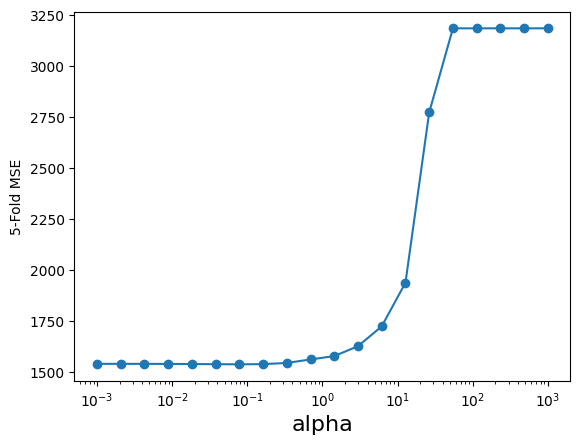

In [183]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-3,3,20)
param_grid = {'alpha': alpha_vector }

# 5-fold CV para mejor estimación y menos sesgo
grid = GridSearchCV(Lasso(), scoring='neg_mean_squared_error', param_grid=param_grid, cv=5, verbose=2)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')  
plt.show()

#### Evaluacion LASSO

In [184]:
alpha_optimo = grid.best_params_['alpha']
print(alpha_optimo)

0.07847599703514611


In [185]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

feature_names = pretrain_data_final.columns[1:] # es igual en train y en test

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE Modelo Lasso (train): 1.51e+03
MSE Modelo Lasso (test) : 2.16e+03
RMSE Modelo Lasso (train): 38.8
RMSE Modelo Lasso (test) : 46.5
Host Response Rate -0.8508155237169925
Host Listings Count 8.443862080118954
Host Total Listings Count 5.94440280625335e-14
Latitude 1.3830319909844049
Longitude -0.6080225154509452
Accommodates 21.09453389344847
Bathrooms 5.37500621281427
Bedrooms 7.45538196203108
Beds -4.111468562565617
Square Feet -0.8313301179148596
Weekly Price 2.9085129675008674
Monthly Price 2.8277767530728055
Security Deposit 3.090388500864715
Cleaning Fee 17.324753120638615
Guests Included 3.0557138439915876
Extra People -3.6055826618404505
Minimum Nights -1.291951399603585
Maximum Nights 0.0
Availability 30 4.261698519831631
Availability 60 0.9005301286372946
Availability 90 -2.2773052330256847
Availability 365 0.9967379115690778
Number of Reviews 0.3342220790144614
Review Scores Rating 1.9505526641023114
Review Scores Accuracy 2.0715316419579333
Review Scores Cleanliness 1.611

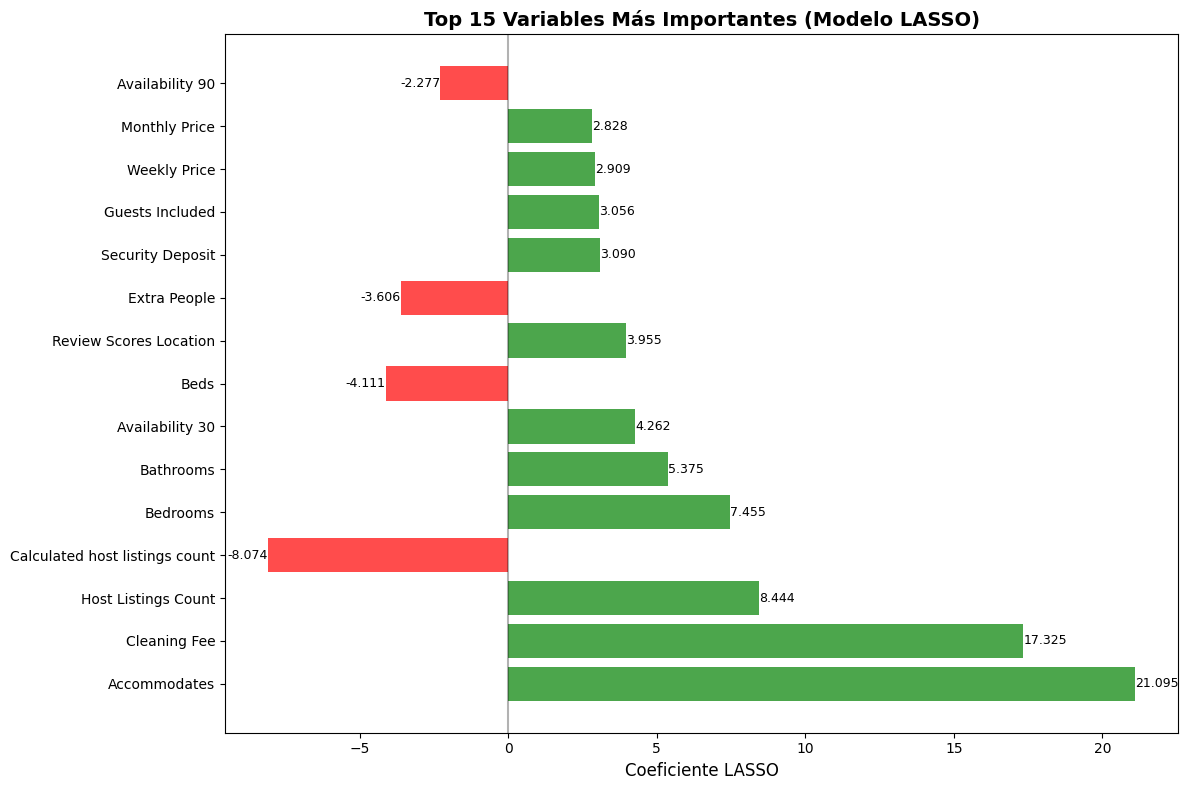

In [194]:
# Gráfico de coeficientes importantes
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el gráfico
plt.figure(figsize=(12, 8))

# Crear DataFrame con coeficientes
coef_df = pd.DataFrame({
    'Variable': feature_names,
    'Coeficiente': w,
    'Coef_Abs': np.abs(w)
}).sort_values('Coef_Abs', ascending=False)

# Variables eliminadas (coeficiente = 0)
variables_eliminadas = coef_df[coef_df['Coeficiente'] == 0]
variables_activas = coef_df[coef_df['Coeficiente'] != 0]

# Solo variables con coeficientes no nulos
variables_importantes = variables_activas.head(15)  # Top 15

# Crear el gráfico de barras
colors = ['green' if x > 0 else 'red' for x in variables_importantes['Coeficiente']]
bars = plt.barh(range(len(variables_importantes)), 
                variables_importantes['Coeficiente'], 
                color=colors, alpha=0.7)

# Personalizar el gráfico
plt.yticks(range(len(variables_importantes)), variables_importantes['Variable'])
plt.xlabel('Coeficiente LASSO', fontsize=12)
plt.title('Top 15 Variables Más Importantes (Modelo LASSO)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Añadir valores en las barras
for i, (bar, valor) in enumerate(zip(bars, variables_importantes['Coeficiente'])):
    plt.text(valor + (0.01 if valor > 0 else -0.01), i, f'{valor:.3f}', 
             va='center', ha='left' if valor > 0 else 'right', fontsize=9)

plt.tight_layout()
plt.show()